## Utilizando Redes Neurais para classificar a base de dados EEG

<p> Uma rede neural tem como objetivo imitar como o cérebro humano aprende. Ela é um mecanismo de aprendizado de máquina muito poderoso, à medida que uma tarefa se torna complicada, há vários perceptrons que formam uma rede que transmitem informações entre si. Um perceptron representa um neurônio. O modelo do Perceptron foi desenvolvido nas décadas de 1950 e 1960 pelo cientista Frank Rosenblatt. Hoje é mais utilizado outros modelos de neurônnios artificias, mas esse seria um modelo básico, como mostra a figura 1, onde o perceptron rece várias entradas, x1; x2; x3 e produz uma única saída binária. </p>

![modelo basico perceptron](https://i0.wp.com/deeplearningbook.com.br/wp-content/uploads/2017/12/perceptron.png?w=280) <center> *figura 1 - Modelo básico de um perceptron* </center>

<p> No modelo da figura 1, o perceptron possui três entradas, x1; x2; x3, para calcular a saída, Rosenblatt introduziu pesos, w1; w2; w3, números reais que representam a importância das entradas para a saída, assim a entrada x1 possui peso w1, x2 peso w2 e x3 peso w3. A saída do neurônio é binária, 0 ou 1, e é determinada pela soma ponderada, Σjwjxj, menor ou maior do que algum valor limiar (threshold), como mostra a figura 2. </p>

![termo algébrico](https://i2.wp.com/deeplearningbook.com.br/wp-content/uploads/2017/12/output.png?w=362) <center> *figura 2 - Modelo algébrico da saída de um perceptron* </center>

<p> O modelo da figura 1 seria um modelo básico de um perceptron, mas atualmente é utilizado modelos mais completos que obtem melhores resultados, como o modelo da figura 3. O modelo da figura 1, simplesmente utiliza uma somatória do produto dos pesos com as entradas, mas esse é um modelo muito simples para determinados problemas. No modelo da figura 3, a função de ativação g(.) usará a saída u em uma função, e o resultado do perceptron será a saída da função g. O simbolo Θ representa o viés (bias), que são utilizados no lugar do threshold, os bias são ajustadas da mesma forma que os pesos sinápticos, o bias permite que um neurônio apresente a saída não nula ainda que todas as suas entradas sejam nulas. O bias representa o quão fácil é fazer o perceptron produzir um 1 (disparar). Um perceptron com um viés muito grande tem uma tendência a emitir um 1, e muito pequeno de emitir 0. </p>

![modelo matemático neuronio](https://i0.wp.com/deeplearningbook.com.br/wp-content/uploads/2018/01/neuronio.jpeg?resize=300%2C137)  <center> *figura 3 - Modelo de perceptron com bia e função de ativação* </center>

<p>O novo modelo utiliza uma função de soma um pouco diferente, ainda é realizado a soma dos produtos dos pesos com as entradas, mas no fim é somado o valor do viés, como mostra a figura 4.</p>

![modelo matemático neuronio](https://i1.wp.com/deeplearningbook.com.br/wp-content/uploads/2017/12/formula.png?w=295)  <center> *figura 4 - Modelo algébrico com o viés* </center>

<p>Um único perceptron não consegue resolver os problemas grandes, para isso é necessário uma rede de perceptrons. Há três categorias de tipos de redes de perceptrons (Arquiteturas):<p>
<ol>
    <li>Redes Neurais Feed-Forward: São mais comuns, a primeira camada é a entrada e a última camada é a saída, se houver uma camada oculta entre as duas, é chamado de redes neurais profundas(Deep Learning). A rede calcula uma série de transformação que altera a semelhança entre os casos, as atividades dos neurônios em cada camada são uma função não-linear das atividades na camada anterior. </li>
    <li>Redes Recorrentes: Essa rede é utilizada quando para se obter o valor de saída atual é necessário analisar o valor do passado. Essa rede é equivalente a redes muito profundas com uma camada oculta por fatia de tempo; exceto que eles usam os mesmos pesos em cada fatia de tempo e recebem entrada em cada fatia. Eles têm a capacidade de lembrar informações em seu estado oculto por um longo período de tempo, mas é muito difícil treiná-las para usar esse potencial. Podem possuir uma dinâmica complicada, sendo difíceis de treinar, mas são mais biologicamente realistas.</li>
    <li>Redes Conectadas Simetricamente: São como as redes recorrentes mas elas possuem o mesmo peso em ambas as direções.  As redes conectadas simetricamente sem unidades ocultas são chamadas de “Redes Hopfield”. As redes conectadas simetricamente com unidades ocultas são chamadas de “Máquinas de Boltzmann”. </li>
</ol>    

O trabalho atual se enquadra na categoria Redes Neurais Feed-Forward, a arquitetura utilizada é a Redes Multilayer Perceptrons (MLP), a rede MLP é composta por mais de um perceptron, e possui uma camada de entrada, uma de saída que toma uma decisão sobre a entrada, e entre as duas pode haver várias camadas ocultas. O MLP é muito utilizado em problemas de aprendizagem supervisionados, ele treina um conjunto de pares entrada-saída e aprende a modelar a correlação entre as entradas e saídas, no treinamento é realizado o ajuste dos parâmetros, pesos e bias da rede para conseguir minimizar o erro.  O backpropagation é usado para fazer os ajustes dos pesos e de bias em relação ao erro, e o próprio erro pode ser medido de várias maneiras, inclusive pelo erro quadrático médio.


Para a implementação do projeto foi utilizado a biblioteca Keras, entre outras que são importadas no primeiro bloco do código.

In [1]:
#importando bibliotecas necessárias no projeto
from sklearn import svm
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.python.client import device_lib
from sklearn.svm import SVC
from keras import utils as np_utils
from keras import backend
import tensorflow as tf
import numpy as np
import csv
import matplotlib.pyplot as plt
from re import search
import numpy as np
from subprocess import getoutput as gop
import glob
import pandas as pd
import csv
import random
import mne

Using TensorFlow backend.


### Carregando conjuntos de treino e teste

Para utilizar a rede neural, é necessário ter lido os dados, o código do primeiro bloco abaixo lê os dados da base de dados 'large'. Os dados são separados em dois vetores, sendo um de alcoólatras e outro de não alcoólatras.

In [2]:
# identificando pastas
folders = {
    'small': 'dataset/small',
    'large_train': 'dataset/large_train',
    'large_test': 'dataset/large_test',
}

def extract_avg(ch_names, data):
    ch_types = ['eeg'] * 64
    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    
    data = data.reshape(len(data)*len(data[0]), 64, 256)
    md = []
    
    for element in data:
        raw = mne.io.RawArray(element, info, verbose=False)
        raw.drop_channels(['x', 'nd', 'y'])

        montage = mne.channels.read_montage('standard_1020')
        raw.set_montage(montage)
        raw, media = mne.set_eeg_reference(raw, 'average', verbose=False)
        md.append(media)

    return md

def load_data_by_S(dataset):
    ch_names = []
    create_ch_name = False
    
    data_dir = gop('ls {}'.format(folders[dataset])).split('\n')
    # 1ª dimensão dos dados contendo os sujeitos
    
    subjects_ctrl_S1_obj = list()
    subjects_ctrl_S2_match = list()
    subjects_ctrl_S2_nomatch = list()
    subjects_alc_S1_obj = list()
    subjects_alc_S2_match = list()
    subjects_alc_S2_nomatch = list()
    
    for types in data_dir:
        files = gop('ls {}/{}'.format(folders[dataset], types)).split('\n')
        # 2ª dimensão dos dados contendo as sessões (trials)
        trials_S1_obj = list()
        trials_S2_match = list()
        trials_S2_nomatch = list()
        
        is_alc = True
        
        for f in files:
            arquivo = open('{}/{}/{}'.format(folders[dataset], types, f))
            text = arquivo.readlines()
            
            s1_obj = False
            s2_nomatch = False
            s2_match = False
            
            alc = search('co2a', text[0])
            ctrl = search('co2c', text[0])
            
            if ctrl:
                is_alc = False
            # 3ª dimensão dos dados contendo os canais (eletrodos)
            chs_s1 = list()
            chs_s2_nomatch = list()
            chs_s2_match = list()
            # 4ª dimensão dos dados contendo os valores em milivolts
            values = list()
            for line in text:
                t = search('(?P<ch_name>\w{1,3}) chan \d{1,2}', line)
                p = search('^\d{1,3}\ \w{1,3}\ \d{1,3}\ (?P<value>.+$)', line)
                s = search('S\w (?P<s_name>\w{2,9})', line)
                if s:
                    if s.group('s_name') == 'obj':
                        s1_obj = True
                    elif s.group('s_name') == 'match':
                        s2_match = True                    
                    elif s.group('s_name') == 'nomatch':
                        s2_nomatch = True

                if p:
                    values.append(float(p.group('value')))
                # mudou para outro eletrodo
                elif t:
                    if values:
                        if s1_obj:
                            chs_s1.append(values)
                        elif s2_match:
                            chs_s2_match.append(values)
                        elif s2_nomatch:
                            chs_s2_nomatch.append(values)                            
                        values = list()
                    if not create_ch_name:
                        ch_names.append(t.group('ch_name').lower())
            
            create_ch_name = True
            if s1_obj == True:
                chs_s1.append(values)
                trials_S1_obj.append(chs_s1)
            elif s2_match == True:
                chs_s2_match.append(values)
                trials_S2_match.append(chs_s2_match)
            elif s2_nomatch == True:
                chs_s2_nomatch.append(values)
                trials_S2_nomatch.append(chs_s2_nomatch)
            
            arquivo.close()
        if is_alc:
            subjects_alc_S1_obj.append(trials_S1_obj)
            subjects_alc_S2_match.append(trials_S2_match)
            subjects_alc_S2_nomatch.append(trials_S2_nomatch)
            
        else:
            subjects_ctrl_S1_obj.append(trials_S1_obj)
            subjects_ctrl_S2_match.append(trials_S2_match)
            subjects_ctrl_S2_nomatch.append(trials_S2_nomatch)
        
    dt_alc_s1 = np.array(subjects_alc_S1_obj)
    dt_alc_s2_match = np.array(subjects_alc_S2_match)
    dt_alc_s2_nomatch = np.array(subjects_alc_S2_nomatch)
    dt_ctrl_s1 = np.array(subjects_ctrl_S1_obj)
    dt_ctrl_s2_match = np.array(subjects_ctrl_S2_match)
    dt_ctrl_s2_nomatch = np.array(subjects_ctrl_S2_nomatch)
    
    md_alc_s1 = np.asarray(extract_avg(ch_names, dt_alc_s1))
    md_alc_s2_match = np.asarray(extract_avg(ch_names, dt_alc_s2_match))
    md_alc_s2_nomatch = np.asarray(extract_avg(ch_names, dt_alc_s2_nomatch))
    md_ctrl_s1 = np.asarray(extract_avg(ch_names, dt_ctrl_s1))
    md_ctrl_s2_match = np.asarray(extract_avg(ch_names, dt_ctrl_s2_match))
    md_ctrl_s2_nomatch = np.asarray(extract_avg(ch_names, dt_ctrl_s2_nomatch))
    
    return md_alc_s1, md_alc_s2_match, md_alc_s2_nomatch, md_ctrl_s1, md_ctrl_s2_match, md_ctrl_s2_nomatch

In [3]:
md_lg_alc_s1, md_lg_alc_s2_match, md_lg_alc_s2_nomatch, md_lg_ctrl_s1, md_lg_ctrl_s2_match, md_lg_ctrl_s2_nomatch = load_data_by_S('large_train')
md_lg_alc_s1_test, md_lg_alc_s2_match_test, md_lg_alc_s2_nomatch_test, md_lg_ctrl_s1_test, md_lg_ctrl_s2_match_test , md_lg_ctrl_s2_nomatch_test = load_data_by_S('large_test')

O próximo passo é criar os vetores de resultados, os dados lidos no vetor md_alc, representam os alcoólatras, logo nesse vetor de saída será inserido True, no vetor md_ctrl será inserido o valor False no vetor de saída, pois estes representão os não alcoólatras. O próximo passo é concatenar os dados dos dois vetores, md_alc e md_ctrl, pois a rede neural precisa de um vetor de entrada somente, com isso foi criado o vetor md_total que representa a concatenação dos dois. As mesmas etapas são feitas tanto para treino quanto para teste.

In [101]:
#print(md_lg_alc_s1)

def criaSaida(media, isAlcoolatra):
    y_md = []
    count = 0
    for i in range(len(media)):
        y_md.insert(count, isAlcoolatra)
        count += 1
    return y_md


def juntaDadosComResultado(dados, saida):
    md_array = []
    md_total_com_y = []
    count = 0
    count_md = 0
    i = 0
    for item in dados:
        for subitem in item:
            md_total_com_y.insert(count, subitem)
            count += 1
        md_total_com_y.insert(count, saida[i])
        count = 0
        md_array.insert(count_md, md_total_com_y)
        md_total_com_y = []
        count_md += 1
        i += 1
    return md_array

def juntaDadosComResultado(medias, saidas):
    md_total_com_y = []
    posAtual = 0
    for arrays in medias:
        aux = []
        for item in arrays:
            aux.append(item)
        aux.append(saidas[posAtual])
        posAtual += 1
        md_total_com_y.append(aux)
    return md_total_com_y


In [122]:
#Treino
# md_lg_alc_s1   md_lg_ctrl_s1
# md_lg_alc_s2_match   md_lg_ctrl_s2_match
# md_lg_alc_s2_nomatch   md_lg_ctrl_s2_nomatch

y_md_alc = criaSaida(md_lg_alc_s1, True)
y_md_ctrl = criaSaida(md_lg_ctrl_s1, False)

md_total = np.concatenate((md_lg_alc_s1, md_lg_ctrl_s1))
y_md_total = np.concatenate((y_md_alc, y_md_ctrl))

#Teste
# md_lg_alc_s1_test    md_lg_ctrl_s1_test
# md_lg_alc_s2_match_test    md_lg_ctrl_s2_match_test
# md_lg_alc_s2_nomatch_test   md_lg_ctrl_s2_nomatch_test

y_md_alc_test = criaSaida(md_lg_alc_s1_test, True)
y_md_ctrl_test = criaSaida(md_lg_ctrl_s1_test, False)

md_total_test = np.concatenate((md_lg_alc_s1_test, md_lg_ctrl_s1_test))
y_md_total_test = np.concatenate((y_md_alc_test, y_md_ctrl_test))

md_array = juntaDadosComResultado(md_total, y_md_total)
test_array = juntaDadosComResultado(md_total_test, y_md_total_test)

O problema agora é que todos os alcoólatras estão nas primeiras posições, e depois estão todos os não alcoólatras. Para inserir esses dados na rede neural, é necessário misturar os alcoólatras com os não alcoólatras, fazendo um 'shuffle' no vetor. Depois é separado os vetores com os dados e com os resultados.

In [123]:
random.shuffle(md_array)
random.shuffle(test_array)

index = 0
y_train = []
for i in range(len(md_array)):
    result = md_array[i][256] #Vetor de resultados
    y_train.insert(index, result)
    index += 1

for i in range(len(md_array)):
    del(md_array[i][256])

x_train = md_array
y_train = y_train

index = 0
y_test = []
for i in range(len(test_array)):
    result = test_array[i][256] #Vetor de resultados
    y_test.insert(index, result)
    index += 1

for i in range(len(test_array)):
    del(test_array[i][256])

x_test = test_array
y_test = y_test


257
256


### Modelo de rede neural

A rede neural terá como entrada 256 elementos, onde cada elemento significa um sinal obtido pelo eletrodo no período de 1 segundo. Será utilizado 3 camadas, uma de entrada, uma oculta e uma de saída. Além de ter o arquivo de teste, será  separado 25% dos dados de treino para validação.

#### Taxa de aprendizado
A taxa de aprendizado corresponde a quantidade que será mudado os pesos, quanto maior esse valor, mais mudanção são feitas nos pesos de acordo com o erros propagados.

Utilizando a taxa de aprendizado igual a 0,01, notamos que a rede se estabiliza quando atinge o valor de época igual a 9, ele oscila a taxa de acerto até nessa época chegar em 100%.

![código overfit](https://uploaddeimagens.com.br/images/002/125/541/original/taxa0_01.PNG?1558393827)  <center> *figura 1 - Resultado da taxa de aprendizado para 0,01* </center>

Utilizando a taxa de aprendizado igual a 0,1, notamos que a rede melhora quando atinge o valor de época igual a 11, ele oscila a taxa de acerto, chegando até a 87% de acerto

![código overfit](https://uploaddeimagens.com.br/images/002/125/572/original/taxa0_1.PNG?1558394544)  <center> *figura 2 - Resultado da taxa de aprendizado para 0,1* </center>

Como a taxa 0,01 apresentou melhores resultados, iremos utilizar está taxa.

#### Função de ativação
De acordo com as entradas que os neurônios recebem, eles podem alterar o valor para saída ou não, quem controla isso são as funções de ativação, elas permitem que pequenas mudanças nos pesos e bias causem apenas uma pequena alteração na saída. A função de ativação permitirá que uma rede de neurônios artificiais aprenda. A função de ativação utilizada foi a Relu, ela é a função de ativação mais utilizada em redes neurais hoje em dia, comparando com outras funções, ela foi quem obteve o melhor valor de acerto.

#### Overfitting

O overfitting ocorre quando o conjunto de treino se ajusta muito bem, mas se mostra ineficaz para prever os resultados do conjunto de teste. O overfitting acontece quando a rede neural apresenta melhores resultados no treino do que no teste.
O overfitting ocorreu quando utilizamos 15 épocas.
![código overfit](https://uploaddeimagens.com.br/images/002/125/600/original/overfit.PNG?1558395170)  <center> *figura 3 - Resultado do overfitting* </center>

Train on 150 samples, validate on 50 samples
Epoch 1/15
150/150 [==============================] - 2s 12ms/step - loss: 0.5302 - acc: 0.4533 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 2/15
150/150 [==============================] - 0s 352us/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 3/15
150/150 [==============================] - 0s 306us/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 4/15
150/150 [==============================] - 0s 293us/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 5/15
150/150 [==============================] - 0s 326us/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 6/15
150/150 [==============================] - 0s 273us/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 7/15
150/150 [==============================] - 0s 273us/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5000 - val_acc: 0.5000
Epoch 8/15
150/150

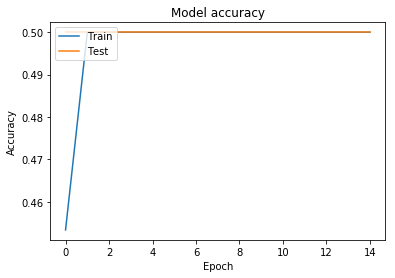

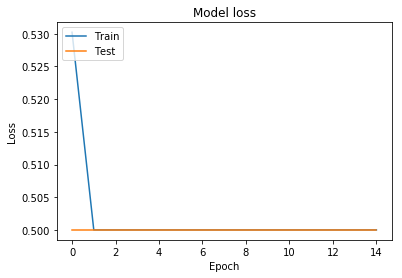

In [118]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

model = Sequential()
model.add(Dense(units=500, activation='relu', input_dim=256))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_split=0.25, epochs=15, batch_size=16, verbose=1)

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=16)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#### Regularização

A regularização pode ajudar a reduzir o overfitting. Analisaremos os efeitos de três técnicas de regularização no 
código, a técnica L1, L2 e Dropout. A intenção da regularização é fazer com que a rede prefira aprender pesos pequenos. Os pesos grandes só são permitidos se melhorarem bastante a primeira parte da função de custo, ou seja, ela tenta encontrar pequenos pesos e minimizar a função de custo original.

Tanto na técnica L1 quanto na L2 o resultado é a diminuição dos valores dos pesos, mas a maneira como os pesos diminuem é diferente. Quando um peso específico tem uma grande magnitude, a regularização L1 reduz o peso muito menos do que a Regularização L2, mas, quando |w| é pequeno, a regularização L1 reduz o peso muito mais do que a regularização L2, assim a regularização L1 tende a concentrar o peso da rede em um número relativamente pequeno de conexões de alta importância, enquanto os outros pesos são direcionados para zero.

##### L1

Configurações utilizadas no modelo de regularização L1:

In [75]:
model = Sequential()
model.add(Dense(units=500, activation='relu', input_dim=256, activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(units=250, activation='relu', activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_split=0.25, epochs=15, batch_size=16, verbose=1)

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=16)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 96 samples, validate on 32 samples
Epoch 1/15
96/96 [==============================] - 2s 21ms/step - loss: 103.2019 - acc: 0.5000 - val_loss: 76.1942 - val_acc: 0.4062
Epoch 2/15
96/96 [==============================] - 0s 488us/step - loss: 44.7409 - acc: 0.5521 - val_loss: 50.4291 - val_acc: 0.4062
Epoch 3/15
96/96 [==============================] - 0s 651us/step - loss: 23.7455 - acc: 0.5417 - val_loss: 35.1454 - val_acc: 0.4062
Epoch 4/15
96/96 [==============================] - 0s 488us/step - loss: 13.5120 - acc: 0.4792 - val_loss: 40.4532 - val_acc: 0.4062
Epoch 5/15
96/96 [==============================] - 0s 651us/step - loss: 12.5568 - acc: 0.5208 - val_loss: 17.9689 - val_acc: 0.4062
Epoch 6/15
96/96 [==============================] - 0s 488us/step - loss: 4.7019 - acc: 0.5312 - val_loss: 13.5858 - val_acc: 0.4375
Epoch 7/15
96/96 [==============================] - 0s 651us/step - loss: 2.3279 - acc: 0.5312 - val_loss: 11.8466 - val_acc: 0.4375
Epoch 8/15
96/96 [==

Para a regularização L1 com o valor de 0,01 ainda não foi suficiente para realizar a regularização do overfitting, como mostra a figura 2:

![código overfit](https://uploaddeimagens.com.br/images/002/122/539/full/l1_001.PNG?1558332348)  <center> *figura 2 - Regularização L1 - 0,001* </center>

Foi obtido uma regularização L1 do overfitting utilizando como parâmetro o valor 0,1, como mostra a figura 3:

![código overfit](https://uploaddeimagens.com.br/images/002/122/540/full/l1-0_1.PNG?1558332818)  <center> *figura 3 - Regularização L1 - 0,1* </center>

##### L2 

Configurações utilizadas no modelo de regularização L2:

In [77]:
model = Sequential()
model.add(Dense(units=500, activation='relu', input_dim=256, activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(units=250, activation='relu', activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit(x_train, y_train, validation_split=0.25, epochs=15, batch_size=16, verbose=1)

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=16)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 96 samples, validate on 32 samples
Epoch 1/15
96/96 [==============================] - 2s 23ms/step - loss: 6099966395564306.0000 - acc: 0.4583 - val_loss: 6222304526863433728.0000 - val_acc: 0.4688
Epoch 2/15
96/96 [==============================] - 0s 651us/step - loss: 5227933728218304790716559600386048.0000 - acc: 0.5417 - val_loss: 2775781174485405118661688866503655424.0000 - val_acc: 0.4062
Epoch 3/15
96/96 [==============================] - 0s 814us/step - loss: inf - acc: 0.5312 - val_loss: inf - val_acc: 0.4062
Epoch 4/15
96/96 [==============================] - 0s 814us/step - loss: inf - acc: 0.5312 - val_loss: inf - val_acc: 0.4062
Epoch 5/15
96/96 [==============================] - 0s 651us/step - loss: inf - acc: 0.5312 - val_loss: inf - val_acc: 0.4062
Epoch 6/15
96/96 [==============================] - 0s 651us/step - loss: inf - acc: 0.5312 - val_loss: inf - val_acc: 0.4062
Epoch 7/15
96/96 [==============================] - 0s 814us/step - loss: inf - acc: 0.

Para a regularização L2 com o valor de 0,01 ainda não foi suficiente para realizar a regularização do overfitting, como mostra a figura 4:

![código overfit](https://uploaddeimagens.com.br/images/002/122/541/full/l2-0_01.PNG?1558333369)  <center> *figura 4 - Regularização L2 - 0,01* </center>

Foi obtido uma regularização L2 do overfitting utilizando como parâmetro o valor 0,1, como mostra a figura 5:

![código overfit](https://uploaddeimagens.com.br/images/002/122/546/full/l2-0_1.PNG?1558333520)  <center> *figura 5 - Regularização L2 - 0,1* </center>

#### Hiperparâmetros

Alguns hiperparâmetros podem ser mudados a fim de se obter um melhor resultado.

Utilizando 250 neuronios na segunda camada, e utilizando o metodo de otimização Adam, foi obtido melhores resultados que o sgd, conseguimos alcançar uma taxa de acerto de 100%.

![código overfit](https://uploaddeimagens.com.br/images/002/125/644/full/hiper.PNG?1558396188)  <center> *figura 6 - Hiperparâmetros* </center>

Train on 180 samples, validate on 20 samples
Epoch 1/20
180/180 [==============================] - 0s 3ms/step - loss: 2.2199 - acc: 0.4667 - val_loss: 1.4756 - val_acc: 0.4000
Epoch 2/20
180/180 [==============================] - 0s 510us/step - loss: 0.8860 - acc: 0.7389 - val_loss: 1.7827 - val_acc: 0.2500
Epoch 3/20
180/180 [==============================] - 0s 540us/step - loss: 0.4061 - acc: 0.8444 - val_loss: 1.8059 - val_acc: 0.5000
Epoch 4/20
180/180 [==============================] - 0s 648us/step - loss: 0.2872 - acc: 0.9056 - val_loss: 1.1210 - val_acc: 0.5000
Epoch 5/20
180/180 [==============================] - 0s 571us/step - loss: 0.3243 - acc: 0.8722 - val_loss: 1.3898 - val_acc: 0.5000
Epoch 6/20
180/180 [==============================] - 0s 549us/step - loss: 0.5740 - acc: 0.8500 - val_loss: 2.8103 - val_acc: 0.4000
Epoch 7/20
180/180 [==============================] - 0s 465us/step - loss: 0.4956 - acc: 0.8833 - val_loss: 1.9887 - val_acc: 0.4500
Epoch 8/20
180/180 

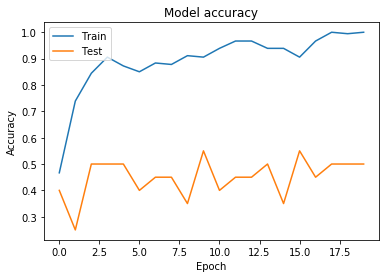

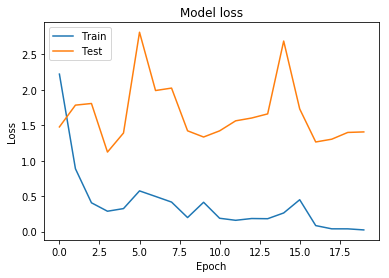

In [120]:
model = Sequential()
model.add(Dense(units=500, activation='relu', input_dim=256))
model.add(Dense(units=250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=16, verbose=1)

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=16)
#print("\n Taxa de acerto: %.2f%%" % (loss_and_metrics[1]*100))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#print("\n Função de Custo: %.2f%%" % (loss_and_metrics[0]))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
